## Prototype LABELATOR with anndata pytorch loader

### overview.
This notebook protypes a "labelator".  The purpose of a "labelator" is to easily classify _cell types_ for out-of-sample "Test" data. 

Currently we are prototyping with `anndata`.  Crucially it is their anndata loader which is especially useful. AND to state our confirmation bias, it impliments the SCVI models which we like.

We will validate potential models and calibrate them with simple expectations using a typical "Train"/"Validate" and "Test"/"Probe" approach.  


Definitions:
- "Train": data samples on which the model being tested is trained.  The `torch lightning` framework used by `scvi-tools` semi-automatically will "validate" to test out-of-sample prediction fidelity during training.
- "Test": held-out samples to test the fidelity of the model.  
- "Probe": data generated externally,which is _probing_ the fidelity of the model to general scRNAseq data.

-----------------
### Data:
All models will be trained on the n=3000 most highly variable genes from Xylena's scRNAseq data.  

```python 
continuous_covariate_keys = None #noise = ['doublet_score', 'percent.mt', 'percent.rb'] # aka "noise"
layer = "counts"
batch = "sample" #'batch'
categorical_covariate_keys = None #['sample', 'batch'] Currently limited to single categorical...
labels = 'cell_type'
size_factor_key = None # library size 
```
----------------
### Models:
Our general approach will be to "compress" the raw count data, and generate probability of each label category.  We will do this in two ways: 

1) **naive** mode.  Or making no assumptions or attempts to account for confounding variables like "batch", "noise" (e.g. doublets, mt/rb contamination), or "library_size".   

2) **transfer** mode.  i.e. `scarches` or `scvi-tools`.  Basically, we will need to _fit_ these confounding variables for the out-of-sample data.

We'll can do this in either a single **end-to-end** way or in two steps. 

#### 2 step: encode + categorize
In two steps:
1) _encode_: embedding the scRNAseq counts into a latent sub-space
    - VAE (e.g. MMD-VAE, infoVAE etc)
    - PCA (_naive_ linear encoding)
    - scVI-latent (__naive__ VAE)
    - etc.
    - scVI (__transfer__ VAE)

2) _categorize_: predicting creating a probability of a each category 
    - Linear classifier (e.g. multinomial Logistic Regression)
    - NN non-linear classifier 
    - boosted trees (XGboost)

We will use a variety of models to "embed" the scRNAseq counts into lower dimension.
- scVI latents

#### end-to-end
We can also try some _end-to-end_ approaches where a single model takes us from raw counts to category probabilities.
- __naive__
    - boosted trees (e.g. xgboost)
    - cVAE
    - trVAE
- __transfer__
    - scANVI


----------------
### training & validation
Models will be trained on the "train" set from xylena's "clean" data.   Validation on a subset of the training data will ensure that overfitting is not a problem.  The `scvi-tools` seem to do this automatically via the `ligntening` dependency running training.

- scVI
    - batch/sample/depth params vs. neutered
- scANVI
    - 


- _naive_ batch correction
- fit a model with a latent "batch" from the 


>scVI: encoder, latent_i, latent_batch_i, latent_library_i, (x_hat = vae(x))

>scANVI: encoder, latent_i, latent_batch_i, latent_library_i, (x_hat = vae(x))


----------------
### inference :: _testing_ :: _probing_
Two types of "inference" modes will be considered.  
1) batch corrected (scVI/scANVI) which requires transfer learning on the probe data
2) naive, which simply processes the examples

------------
### metrics
- pct accuracy  
- ?




## Caveats
There are several gotchas to anticipate:
- features.  Currently we are locked into the 3k genes we are testing with.  Handling subsets and supersets is TBC.
- batch.  In principle each "embedding" or decode part of the model should be able to measure a "batch-correction" parameter explicitly.  in scVI this is explicitly _learned_.  However in _naive_ inference mode it should just be an inferred fudge factor.
- noise.  including or not including `doublet`, `mito`, or `ribo` metrics

In [2]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip uninstall -y typing_extensions
    !pip install --quiet scvi-colab
    from scvi_colab import install
    install()

In [3]:
import gdown
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
import numpy as np
import scanpy as sc
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from anndata.experimental.pytorch import AnnLoader

#### 
import sys
import warnings

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
import scvi
from pathlib import Path
# import scarches as sca


import torch

if sys.platform != "darwin":
    torch.set_float32_matmul_precision("medium")  
else:
    print("MPS backend: ",torch.backends.mps.is_available()) #the MacOS is higher than 12.3+
    print("MPS (built): ",torch.backends.mps.is_built()) #MPS is activated

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
from labelator.utils import mde
from labelator.model._trvae import TRVAE

%load_ext autoreload
%autoreload 2


MPS backend:  True
MPS (built):  True


In [4]:
!pwd

mde

/Users/ergonyc/Projects/SingleCell/labelator/nbs


<function labelator.utils._mde.mde(data: Union[numpy.ndarray, pandas.core.frame.DataFrame, scipy.sparse._base.spmatrix, torch.Tensor], device: Optional[Literal['cpu', 'cuda', 'mps']] = None, **kwargs) -> numpy.ndarray>

### Load Train, Validate Data 

In [7]:
if IN_COLAB:
    root_path = Path("/content/drive/MyDrive/")
    data_path = root_path / "SingleCellModel/data"
else:
    root_path = Path("../")
    if sys.platform == "darwin":
        data_path = root_path / "data/xylena_raw"
    else:
        data_path = root_path / "data/scdata/xylena_raw"
        
XYLENA_ANNDATA = "brain_atlas_anndata.h5ad"
XYLENA_METADATA = "final_metadata.csv"
XYLENA_ANNDATA2 = "brain_atlas_anndata_updated.h5ad"

XYLENA_TRAIN = XYLENA_ANNDATA.replace(".h5ad", "_train.h5ad")
XYLENA_TEST = XYLENA_ANNDATA.replace(".h5ad", "_train.h5ad")



In [8]:
outfilen = data_path / XYLENA_ANNDATA.replace(".h5ad", "_train.h5ad")
train_ad = ad.read_h5ad(outfilen)



In [9]:
subsamples = np.random.choice(train_ad.shape[0], 40_000, replace=False)

In [10]:
train_ad = train_ad[subsamples,:] # no copy... just alias

In [11]:
train_ad.obs['dummy'] = 1

/var/folders/0z/hvx6j8cn6yj3bqbyq6rtsxm40000gn/T/ipykernel_66775/3641250029.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  train_ad.obs['dummy'] = 1


In [13]:
condition_key = 'batch'
condition_key = 'dummy'

cell_type_key = 'cell_type'
source_conditions = train_ad.obs[condition_key].unique().tolist()
train_ad

AnnData object with n_obs × n_vars = 40000 × 3000
    obs: 'seurat_clusters', 'cell_type', 'sample', 'doublet_score', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rb', 'batch', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.3', 'ExN1', 'InN2', 'MG3', 'Astro4', 'Oligo5', 'OPC6', 'VC7', 'type', 'UMAP_1', 'UMAP_2', 'clean', 'test', 'train', 'tmp', 'dummy'
    var: 'feat'

## VAE model definition

Here we define a helper multilayer perceptron class to use it with a VAE below.

In [14]:

trvae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [15]:

trvae = TRVAE(
    adata=train_ad,
    condition_key=condition_key,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 3000 128 1
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 1
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 3000 



The following shows a graphical representation of our VAE model. It uses the unobserved latent variable `Z` and the observed batch labels `Batch` to reconstruct input data `X` and class labels `Class`. Note that the model treats `Class` as an independent variable from `X` given `Z`. 

<img src="./_static/sup_cvae.jpg" width="300px">

Here we define our model, please see the Pyro VAE tutorials for more deatils.

## AnnLoader initialization

Visualize the data using a UMAP through a Scanpy pipeline.

In [16]:
sc.pp.pca(train_ad)



In [17]:
train_ad.obsm['X_mde'] = mde(train_ad.obsm['X_pca'], device="cpu")


perfoming mde on cpu


/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:84: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  dispatcher = jit(_target='npyufunc',
/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:84: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  dispatcher = jit(_target='npyufunc',


We can see that the data has strong batch effects. We want to integrate the studies using our VAE model.

/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


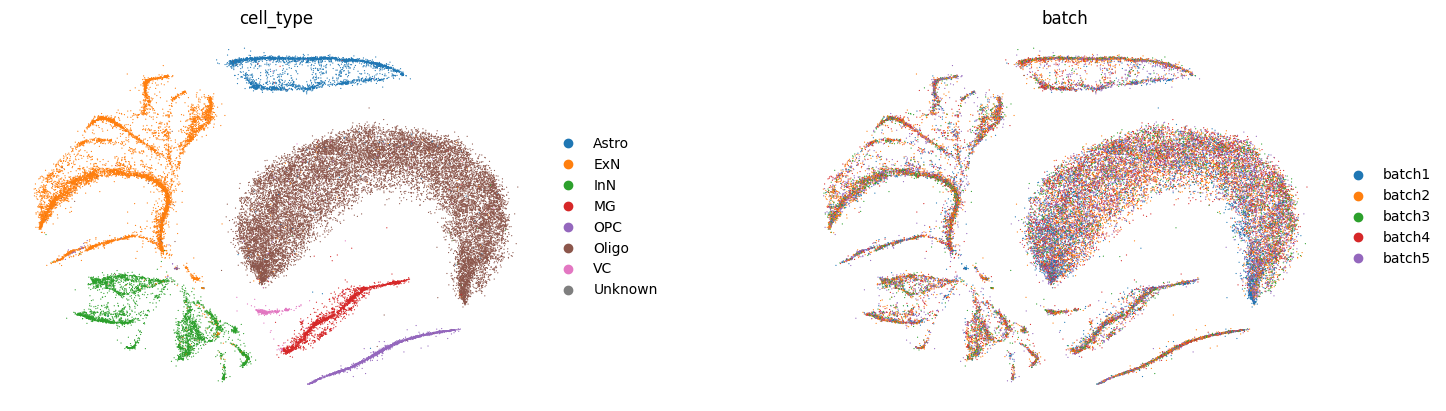

In [18]:
# sc.pl.umap(adata, color=['study', 'cell_type'], wspace=0.35)

sc.pl.embedding(
    train_ad,
    basis="X_mde",
    color=["cell_type", "batch"],
    frameon=False,
    wspace=0.35,
)

In [14]:
# train_ad.X = train_ad.raw.X # put raw counts to .X

For our model we need size factors (library sizes) for each cell for the means of negative binomial reconstruction loss.

In [19]:
train_ad.obs['size_factors'] = train_ad.X.sum(1)

In [20]:
train_ad.obs['sample'].cat.categories

Index(['KEN-1066-ARC', 'KEN-1070-ARC', 'KEN-1095-ARC', 'KEN-1127-ARC',
       'KEN-1132-ARC', 'KEN-1142-ARC', 'KEN-1159-ARC', 'KEN-1163-ARC',
       'KEN-1177-ARC', 'KEN-1184-ARC', 'KEN-1206-ARC', 'KEN-1221-ARC',
       'KEN-1229-ARC', 'KEN-5015-ARC', 'KEN-5034-ARC', 'KEN-5062-ARC',
       'KEN-5091-ARC', 'KEN-5163-ARC', 'SH-04-19-ARC', 'SH-05-10-ARC',
       'SH-06-05-ARC', 'SH-06-25-ARC', 'SH-06-66-ARC', 'SH-07-28-ARC',
       'SH-07-46-ARC', 'SH-07-63-ARC', 'SH-08-04-ARC', 'SH-92-05-ARC',
       'SH-95-02-ARC', 'SH-96-08-ARC', 'UMARY-26-ARC', 'UMARY-165-ARC',
       'UMARY-177-ARC', 'UMARY-544-ARC', 'UMARY-634-ARC', 'UMARY-650-ARC',
       'UMARY-671-ARC', 'UMARY-813-ARC', 'UMARY-818-ARC', 'UMARY-819-ARC',
       'UMARY-879-ARC', 'UMARY-914-ARC', 'UMARY-933-ARC', 'UMARY-1135-ARC',
       'UMARY-1206-ARC', 'UMARY-1266-ARC', 'UMARY-1363-ARC', 'UMARY-1378-ARC',
       'UMARY-1379-ARC', 'UMARY-1406-ARC', 'UMARY-1410-ARC', 'UMARY-1442-ARC',
       'UMARY-1454-ARC', 'UMARY-1461-ARC', 'UMA

In [21]:
train_ad.obs['dummy'] = 1
encoder_study = OneHotEncoder(sparse=False, dtype=np.float32)


In [22]:


encoder_study.fit(train_ad.obs['dummy'].to_numpy()[:, None])

/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(dtype=<class 'numpy.float32'>, sparse=False, sparse_output=False)

In [23]:
train_ad.obs['cell_type'].cat.categories

Index(['Astro', 'ExN', 'InN', 'MG', 'OPC', 'Oligo', 'VC', 'Unknown'], dtype='object')

In [24]:
n_cats = len(train_ad.obs['cell_type'].cat.categories)

In [25]:
encoder_celltype = LabelEncoder()
encoder_celltype.fit(train_ad.obs['cell_type'])

LabelEncoder()

You can create the converter with a function or a Mapping of functions which will be applied to the values of attributes (`.obs`, `.obsm`, `.layers`, `.X`) or to specific keys of these attributes in the subset object. Specify an attribute and a key (if needed) as keys of the passed Mapping and a function to be applied as a value.

Here we define a converter which will transform the values of the keys `'study'` and `'cell_type'` of `.obs` using the encoders created above.

In [26]:
encoders = {
    'obs': {
        'dummy': lambda s: encoder_study.transform(s.to_numpy()[:, None]),
        'cell_type': encoder_celltype.transform
    }
}

# encoders = {
#     'obs': {
#         'sample': lambda s: np.ones_like(s.to_numpy())[:, None],
#         'cell_type': encoder_celltype.transform
#     }
# }


Here we create an AnnLoader object which will return a PyTorch dataloader properly set for our AnnData object. 

The `device="cuda"` (or )`device="mps"` for apple silicon) parameter indicates that we want to lazily convert all numeric values in the AnnData object. By lazy conversion we mean that no data is converted until you access it. The AnnLoader object creates a wrapper object from the provided AnnData object and it takes care about subsetting and conversion. No copying of the full AnnData object happens here.

The encoders passed to `convert` are applied before sending anything to accelerator.

In [27]:
dataloader = AnnLoader(train_ad, batch_size=128, shuffle=True, convert=encoders, device="mps")

This is the wrapper object mentioned above. The dataloader itetarates through this object.

Note that if `device="cuda"`, then all numeric values will be converted to tensors and sent to cuda, so you don't need to do any conversion during the training phase. (This is a hacked local version of anndata to support mps)

`view of obsm` means that the wrapper object doesn't copy anything from .obsm of the underlying AnnData object. `obs` insted of `view of obs` means that the object copied .obs from the AnnData object. You can configure what is copied, please see the AnnCollection tutorial for deatils. The wrapper object (AnnCollection) never copies the full .X or .layers from the underlying AnnData object, all conversions happen when the AnnCollection object is subset.

Note that the numeric values in a subset is already converted and sent to cuda (if needed).

In [28]:
batch = dataloader.dataset[:10]

print('X:', batch.X.device, batch.X.dtype)
print('X_pca:', batch.obsm['X_pca'].device, batch.obsm['X_pca'].dtype)
# print('X_umap:', batch.obsm['X_umap'].device, batch.obsm['X_umap'].dtype)
# and here you can see that the converters are applied to 'study' and 'cell_type'.
print('dummy', batch.obs['dummy'].device, batch.obs['dummy'].dtype)
print('cell_type:', batch.obs['cell_type'].device, batch.obs['cell_type'].dtype)
print('size_factors:', batch.obs['size_factors'].device, batch.obs['size_factors'].dtype)

X: mps:0 torch.float32
X_pca: mps:0 torch.float32
dummy mps:0 torch.float32
cell_type: mps:0 torch.int64
size_factors: mps:0 torch.float32


In [36]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    )

NameError: name 'trvae2' is not defined

In [34]:
trvae.is_trained_

True

In [37]:
trvae2 = TRVAE(
    adata=train_ad,
    condition_key=condition_key,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 3000 128 1
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 1
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 3000 



In [41]:
trvae2.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    device = "mps",
    use_stratified_sampling = False
)

Preparing (40000, 3000)
Instantiating dataset


NotImplementedError: The operator 'aten::lgamma.out' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [35]:
trvae.save("trvae_brain_atlas")

In [29]:
batch

AnnCollectionView object with n_obs × n_vars = 10 × 3000
    obsm: 'X_pca', 'X_mde'
    obs: 'seurat_clusters', 'cell_type', 'sample', 'doublet_score', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rb', 'batch', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.3', 'ExN1', 'InN2', 'MG3', 'Astro4', 'Oligo5', 'OPC6', 'VC7', 'type', 'UMAP_1', 'UMAP_2', 'clean', 'test', 'train', 'tmp', 'dummy', 'size_factors'

You can also use a custom sampler instead of the default one with automatic bacthing in `AnnLoader`. Just pass your `sampler` and `batch_size`.

In [30]:
# from torch.utils.data import WeightedRandomSampler
batch.X

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 2.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='mps:0')

In [31]:
# weights = np.ones(train_ad.n_obs)
# weights[train_ad.obs['cell_type'] == 'Pancreas Stellate'] = 2.
# sampler = WeightedRandomSampler(weights, train_ad.n_obs)

In [32]:
# dataloader = AnnLoader(train_ad, batch_size=128, sampler=sampler, convert=encoders, use_cuda=use_cuda)

We don't use the custom sampler for training the model, so return to the default sampler here.

## Initialize and train the model

Here we initialize the model and the Pyro routines for training.

In [67]:
n_conds = len(train_ad.obs['sample'].cat.categories)
n_classes = len(train_ad.obs['cell_type'].cat.categories)
n_conds = 1
cvae = CVAEpyro(train_ad.n_vars, n_conds=n_conds, n_classes=n_classes, hidden_dims=[128, 128], latent_dim=10)

device = "mps"
if device in ["cuda","mps"]: cvae.to(device)

In [68]:
optimizer = pyro.optim.Adam({"lr": 1e-3})
svi = pyro.infer.SVI(cvae.model, cvae.guide, optimizer, loss=pyro.infer.TraceMeanField_ELBO())

In [69]:
svi.guide

<bound method CVAEpyro.guide of CVAEpyro(
  (encoder): MLP(
    (fc): Sequential(
      (0): Linear(in_features=3001, out_features=128, bias=True)
      (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.05, inplace=False)
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (6): ReLU()
      (7): Dropout(p=0.05, inplace=False)
      (8): Linear(in_features=128, out_features=20, bias=True)
    )
  )
  (decoder): MLP(
    (fc): Sequential(
      (0): Linear(in_features=11, out_features=128, bias=True)
      (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.05, inplace=False)
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (6): ReLU()
      (7): Dropout(p=0.05, inplace=False)
      (8): Linear(in_features=128, out_features=3

Here is the code for our training phase. The AnnLoader object is passed as a dataloader, it iterates through `dataloader.dataset` (as in a standard PyTorch dataloader).

Note that now you can simply take a batch from the dataloader, select a required attribute, do something with it if needed and pass to your loss function. Everything is already converted by the pre-defined converters. You don't need to copy your AnnData object, you don't need a custom dataloader for a dictionary of required keys, all observation keys are already in the bacthes.

In [70]:
def train(svi, train_loader):
    epoch_loss = 0.
    for batch in train_loader:
        # epoch_loss += svi.step(batch.X, batch.obs['sample'], batch.obs['cell_type'], batch.obs['size_factors'])
        epoch_loss += svi.step(batch.X,  batch.obs['dummy'], batch.obs['cell_type'], batch.obs['size_factors'])
        
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [79]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = str(1)


In [80]:
NUM_EPOCHS = 210

for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, dataloader)
    if epoch % 40 == 0 or epoch == NUM_EPOCHS-1:
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

NotImplementedError: The operator 'aten::lgamma.out' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

## Check the results

In [91]:
full_data = dataloader.dataset[:] # No copies yet, nothing is copied until you access specific attributes (.X, .obsm etc.).

In [92]:
means = cvae.encoder(full_data.X, full_data.obs['sample'])[:, :10] # get mean values of the latent variables

In [93]:
train_ad.obsm['X_cvae'] = means.data.cpu().numpy()

In [94]:
# sc.pp.neighbors(train_ad, use_rep='X_cvae')
# sc.tl.umap(train_ad)

train_ad.obsm['X_mde2'] = scvi.model.utils.mde(train_ad.obsm['X_cvae'])


The results of the study integration using our VAE model.

/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


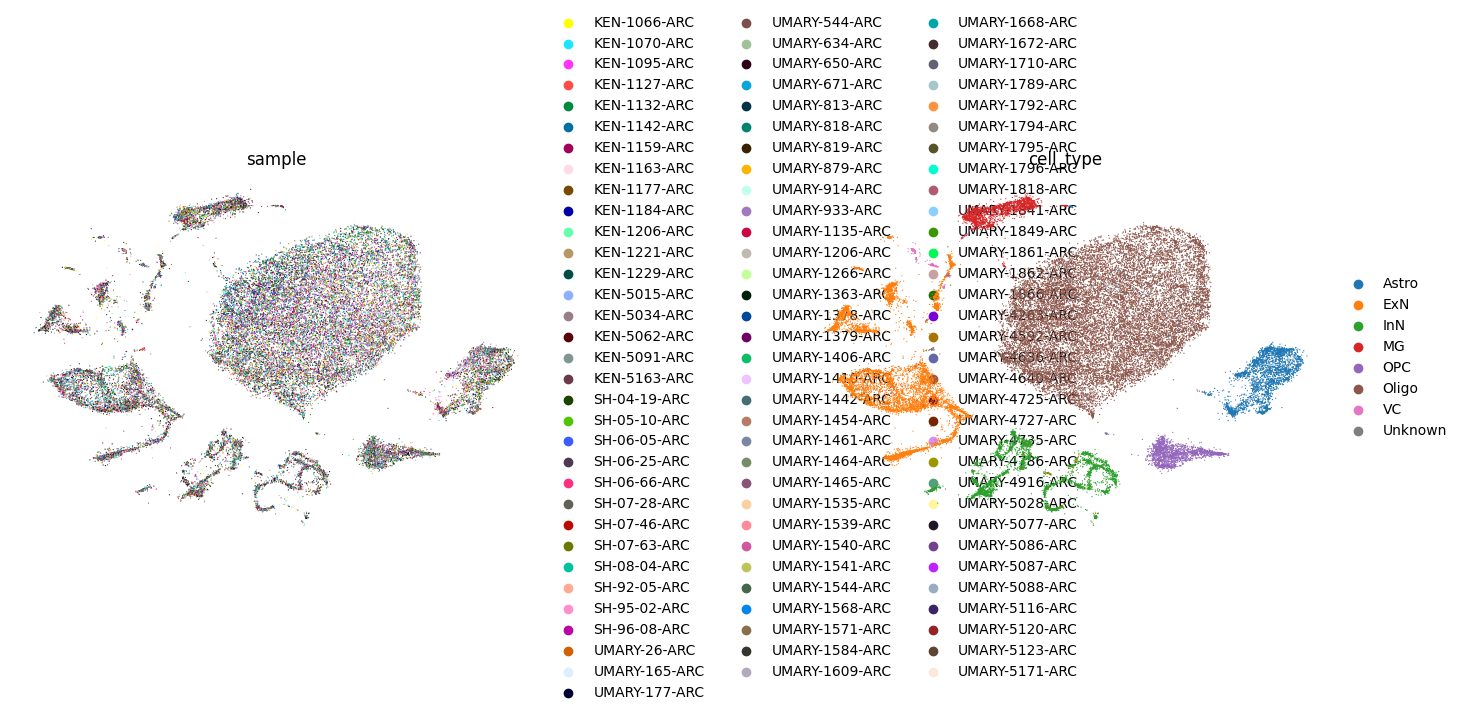

In [95]:
# sc.pl.umap(adata, color=['study', 'cell_type'], wspace=0.35)
# # sc.pl.umap(adata, color=['study', 'cell_type'], wspace=0.35)

sc.pl.embedding(
    train_ad,
    basis="X_mde2",
    color=["sample", "cell_type"],
    frameon=False,
    wspace=0.35,
)


In [117]:
preds = cvae.classifier(means).argmax(dim=-1)
labs = torch.tensor(encoder_celltype.transform(train_ad.obs['cell_type']))
accuracy = (preds==labs).sum().item()/train_ad.n_obs

In [164]:
encoder_celltype.inverse_transform(preds)

array(['VC', 'Oligo', 'ExN', ..., 'MG', 'Oligo', 'Oligo'], dtype=object)

In [99]:
train_ad.n_obs

tensor([[ 2.9354,  1.8235, -0.1486,  ...,  0.0210, -0.0204, -0.0467],
        [-0.2977,  0.7406,  0.3860,  ..., -0.0677,  0.0308, -0.0242],
        [-0.5130,  2.4466,  0.7728,  ...,  0.0406, -0.0267, -0.0259],
        ...,
        [ 1.0070,  1.5476,  1.7903,  ..., -0.0081,  0.0225, -0.0481],
        [-0.5239, -0.5073,  0.7861,  ..., -0.0812,  0.0437,  0.0175],
        [-1.6937, -0.1083,  1.2423,  ..., -0.0870,  0.0597,  0.0088]],
       grad_fn=<SliceBackward0>)

In [186]:
import torch.nn.functional as F
from torch.distributions import Categorical

# Example logits from a neural network output
logits = cvae.classifier(means)

# Applying softmax to convert logits to probabilities
probabilities = F.softmax(logits, dim=1)

# Create a Categorical distribution
distribution = Categorical(probs=probabilities)

# Calculate entropy
entropy = distribution.entropy()

n_classes = probabilities.shape[1]

In [187]:
probabilities[1,:].sum()

tensor(1., grad_fn=<SumBackward0>)

In [188]:

logs = logits.detach().numpy()
probs = probabilities.detach().numpy()
ents = entropy.detach().numpy()
logents = entropy.log().detach().numpy()
maxprob = probs.max(axis=1)

# print("Logits: ", logs)
# print("Probabilities: ", probs)

maxprobs = probs.max(axis=1)


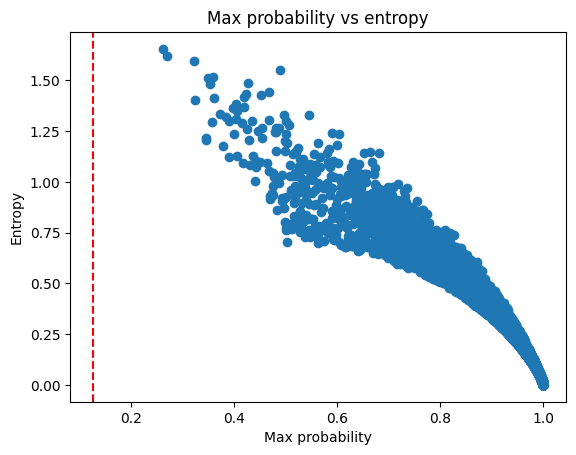

In [190]:
# print("Entropy:", entropy)

# plt.scatter(means[:, 0], means[:, 1], c=entropy)

ax = plt.scatter(maxprobs,ents)
plt.xlabel("Max probability")
plt.ylabel("Entropy")
plt.title("Max probability vs entropy")
plt.axvline(x=1/n_cats, color='r', linestyle='--')


In [191]:
cvae.classifier(means).argmax(dim=-1)

tensor([7, 5, 1,  ..., 3, 5, 5])

In [192]:
torch.topk(probabilities, k=2, dim=1)
top_probs, _ = torch.topk(probabilities, k=2, dim=1)
top_probs[:,0] - top_probs[:,1]

tensor([0.9798, 0.9545, 0.7629,  ..., 0.9801, 0.9962, 0.9995],
       grad_fn=<SubBackward0>)

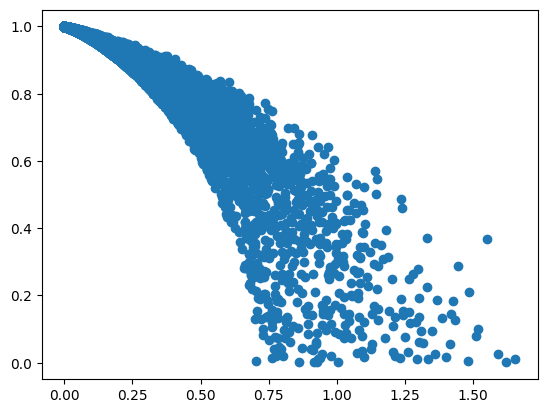

In [193]:
def calculate_margin_of_probability(probabilities):

    # Get the top two probabilities
    top_probs, _ = torch.topk(probabilities, 2)

    # Calculate the margin
    margin = top_probs[:,0] - top_probs[:,1]
    return margin

# Get the top two probabilities
top_probs, _ = torch.topk(probabilities, k=2, dim=1)
# Calculate the margin
margin = top_probs[:,0] - top_probs[:,1]

# margs = calculate_margin_of_probability(probabilities)

plt.scatter(ents,margin.detach().numpy())



In [194]:
train_ad.obs['margin'] = margin.detach().numpy()
train_ad.obs['entropy'] = entropy.detach().numpy()
train_ad.obs['maxprob'] = maxprob
train_ad.obs['pred'] = encoder_celltype.inverse_transform(preds)

/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


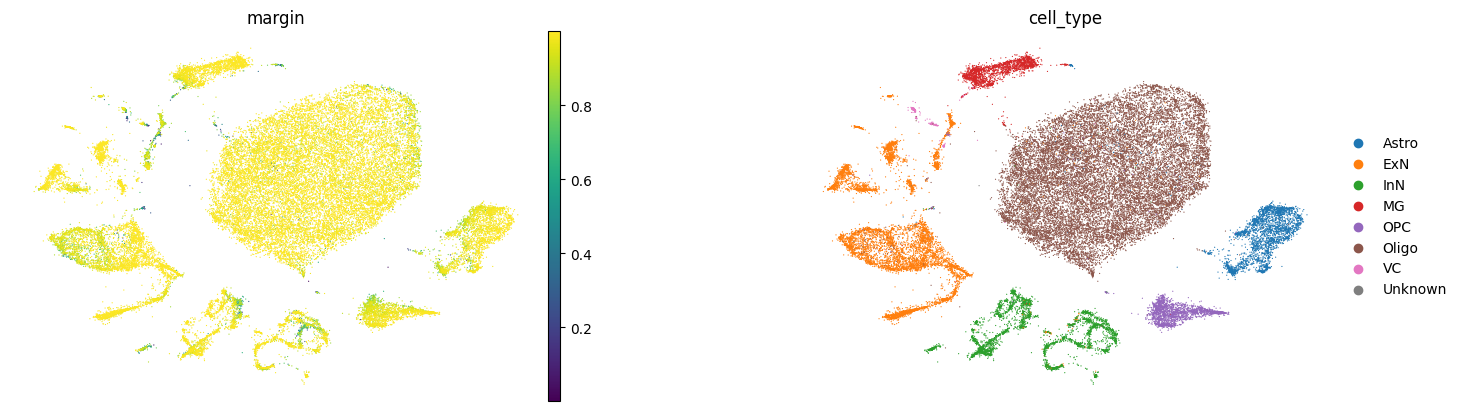

In [195]:
sc.pl.embedding(
    train_ad,
    basis="X_mde2",
    color=["margin", "cell_type"],
    frameon=False,
    wspace=0.35,
)


/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


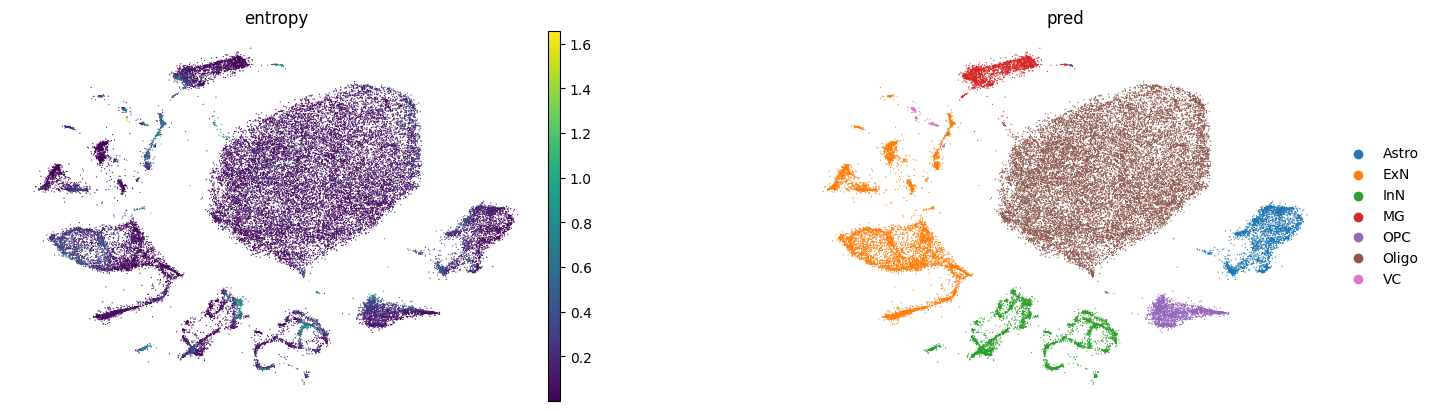

In [196]:
sc.pl.embedding(
    train_ad,
    basis="X_mde2",
    color=["entropy", "pred"],
    frameon=False,
    wspace=0.35,
)


In [198]:
train_ad.obs[train_ad.obs['cell_type']=='Unknown']

,seurat_clusters,cell_type,sample,doublet_score,nCount_RNA,nFeature_RNA,percent.mt,percent.rb,batch,S.Score,...,UMAP_2,clean,test,train,tmp,size_factors,margin,entropy,maxprob,pred
cells,,,,,,,,,,,,,,,,,,,,,
CACATAATCAAACCGT-1_138,1,Unknown,UMARY-933-ARC,0.089965,11383,4936,0.131775,1.511025,batch5,-0.070626,...,-9.666387,True,False,True,nanOligodendrocytes,4374.0,0.236207,1.085259,0.54742,ExN


In [227]:
train_ad.obs['pred']

cells
GATTGGTTCCTGGTGA-1_66        VC
TGCTTAAAGTTATGTG-1_51     Oligo
GATCAGGCAGGCATGA-1_115      ExN
CCATAGCCAAGCTAAA-1_12     Oligo
ATGCAGGCAATATGGA-1_54     Oligo
                          ...  
CAGGAAGGTTGTAACG-1_47     Oligo
AATCATCCATAGCGAG-1_86       InN
GTTGCCCGTGCTGGTG-1_44        MG
CACCAACCACATACTG-1_80     Oligo
CCCGCTTCAGGCATCT-1_89     Oligo
Name: pred, Length: 40000, dtype: category
Categories (7, object): ['Astro', 'ExN', 'InN', 'MG', 'OPC', 'Oligo', 'VC']

TypeError: Categoricals can only be compared if 'categories' are the same.

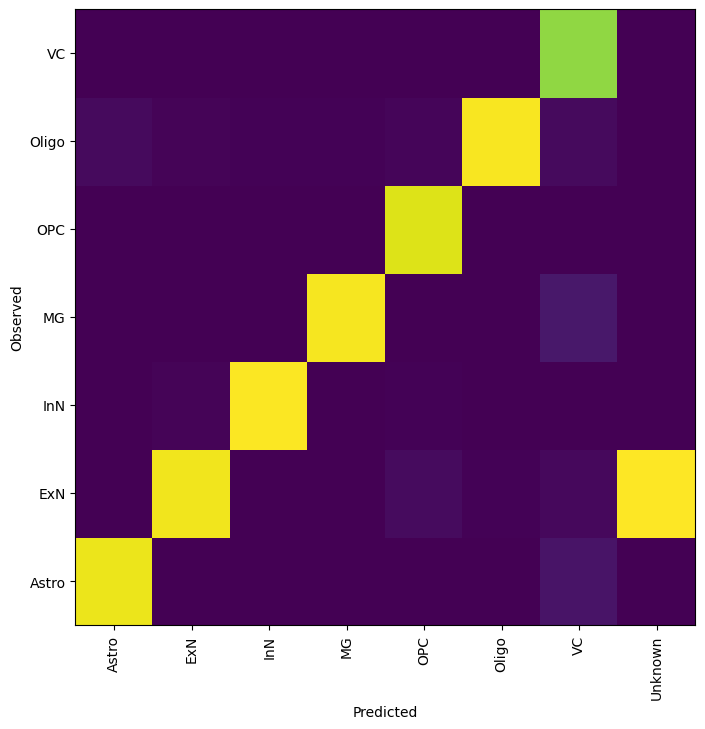

In [231]:
df = train_ad.obs.groupby(["pred", "cell_type"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title(f"scanvi accuracy: {np.mean(train_ad.obs.pred == train_ad.obs.cell_type):.3f}")

## to latent model

In [ ]:
from scvi.nn import DecoderSCVI, Encoder, LinearDecoderSCVI, one_hot


class CVAElat(nn.Module):
    # The code is based on the scarches trVAE model
    # https://github.com/theislab/scarches/blob/v0.3.5/scarches/models/trvae/trvae.py
    # and on the pyro.ai Variational Autoencoders tutorial
    # http://pyro.ai/examples/vae.html
    def __init__(self, input_dim, n_conds, n_classes, hidden_dims, latent_dim):
        super().__init__()
        
        self.encoder = MLP(input_dim+n_conds, hidden_dims, 2*latent_dim) # output - mean and logvar of z
        
        self.decoder = MLP(latent_dim+n_conds, hidden_dims[::-1], input_dim)
        self.theta = nn.Linear(n_conds, input_dim, bias=False)
        
        self.classifier = nn.Linear(latent_dim, n_classes)
        
        self.latent_dim = latent_dim
    
    def model(self, x, batches, classes, size_factors):
        pyro.module("cvae", self)
        
        batch_size = x.shape[0]
        
        with pyro.plate("data", batch_size):
            z_loc = x.new_zeros((batch_size, self.latent_dim))
            z_scale = x.new_ones((batch_size, self.latent_dim))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            
            classes_probs = self.classifier(z).softmax(dim=-1)
            pyro.sample("class", dist.Categorical(probs=classes_probs), obs=classes)
            
            dec_mu = self.decoder(z, batches).softmax(dim=-1) * size_factors[:, None]
            dec_theta = torch.exp(self.theta(batches))
            
            logits = (dec_mu + 1e-6).log() - (dec_theta + 1e-6).log()
            
            pyro.sample("obs", dist.NegativeBinomial(total_count=dec_theta, logits=logits).to_event(1), obs=x.int())
    
    def guide(self, x, batches, classes, size_factors):
        batch_size = x.shape[0]
        
        with pyro.plate("data", batch_size):
            z_loc_scale = self.encoder(x, batches)
            
            z_mu = z_loc_scale[:, :self.latent_dim]
            z_var = torch.sqrt(torch.exp(z_loc_scale[:, self.latent_dim:]) + 1e-4)
            
            pyro.sample("latent", dist.Normal(z_mu, z_var).to_event(1))

## Test & Probe

In [212]:
outfilen = data_path / XYLENA_ANNDATA.replace(".h5ad", "_test.h5ad")
test_ad = ad.read_h5ad(outfilen)

subsamples = np.random.choice(test_ad.shape[0], 10_000, replace=False)
test_ad = test_ad[subsamples,:] # no copy... just alias

In [213]:
condition_key = 'batch'
cell_type_key = 'cell_type'
source_conditions = train_ad.obs[condition_key].unique().tolist()
source_conditions_ = test_ad.obs[condition_key].unique().tolist()
test_ad


View of AnnData object with n_obs × n_vars = 10000 × 3000
    obs: 'seurat_clusters', 'cell_type', 'sample', 'doublet_score', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rb', 'batch', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.3', 'ExN1', 'InN2', 'MG3', 'Astro4', 'Oligo5', 'OPC6', 'VC7', 'type', 'UMAP_1', 'UMAP_2', 'clean', 'test', 'train', 'tmp'
    var: 'feat'

For our model we need size factors (library sizes) for each cell for the means of negative binomial reconstruction loss.

In [214]:

test_ad.obs['size_factors'] = test_ad.X.sum(1)

/var/folders/0z/hvx6j8cn6yj3bqbyq6rtsxm40000gn/T/ipykernel_90416/3503682332.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  test_ad.obs['size_factors'] = test_ad.X.sum(1)


In [215]:
source_conditions, source_conditions_

(['batch3', 'batch5', 'batch1', 'batch2', 'batch4'],
 ['batch1', 'batch5', 'batch2', 'batch4', 'batch3'])

Assume that the encoders are still good. 
```python
n_cats
encoder_celltype
encoders = {
    'obs': {
        'sample': lambda s: encoder_study.transform(s.to_numpy()[:, None]),
        'cell_type': encoder_celltype.transform
    }
}

```

In [216]:
test_dataloader = AnnLoader(test_ad, batch_size=128, shuffle=True, convert=encoders, use_cuda=use_cuda)

In [217]:
source_conditions

['batch3', 'batch5', 'batch1', 'batch2', 'batch4']

## AnnLoader initialization

Visualize the data using a UMAP through a Scanpy pipeline.

In [218]:
sc.pp.pca(test_ad)
test_ad.obsm['X_mde'] = scvi.model.utils.mde(test_ad.obsm['X_pca'])


We can see that the data has strong batch effects. We want to integrate the studies using our VAE model.

/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


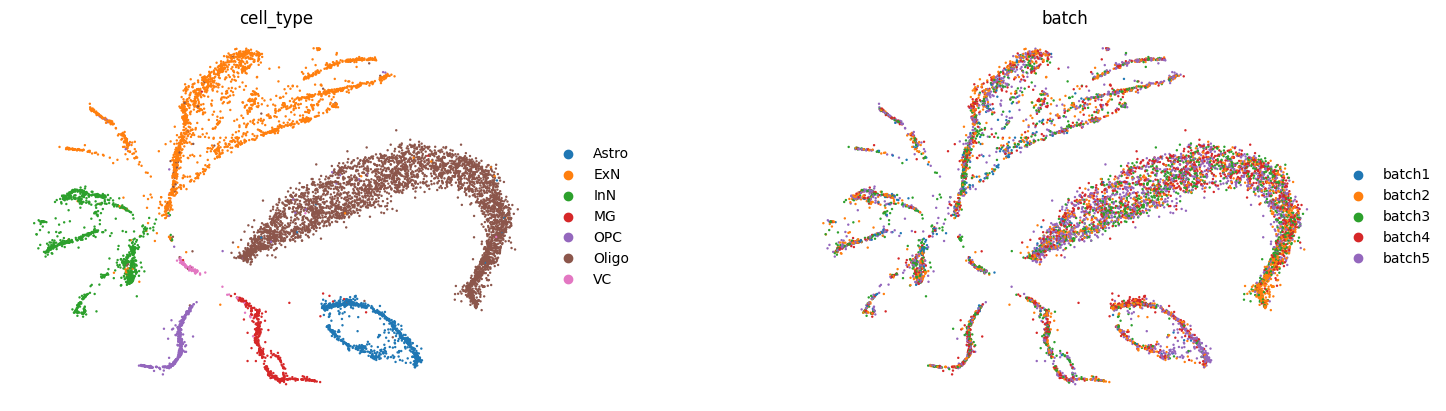

In [219]:
# sc.pl.umap(adata, color=['study', 'cell_type'], wspace=0.35)

sc.pl.embedding(
    test_ad,
    basis="X_mde",
    color=["cell_type", "batch"],
    frameon=False,
    wspace=0.35,
)

In [224]:
# train_ad.X = train_ad.raw.X # put raw counts to .X
train_ad

AnnData object with n_obs × n_vars = 40000 × 3000
    obs: 'seurat_clusters', 'cell_type', 'sample', 'doublet_score', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rb', 'batch', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.3', 'ExN1', 'InN2', 'MG3', 'Astro4', 'Oligo5', 'OPC6', 'VC7', 'type', 'UMAP_1', 'UMAP_2', 'clean', 'test', 'train', 'tmp', 'size_factors', 'margin', 'entropy', 'maxprob', 'pred'
    var: 'feat'
    uns: 'pca', 'cell_type_colors', 'batch_colors', 'sample_colors', 'pred_colors'
    obsm: 'X_pca', 'X_mde', 'X_cvae', 'X_mde2'
    varm: 'PCs'

In [220]:
train_ad.obs['size_factors'] = train_ad.X.sum(1)

In [ ]:
train_ad = train_ad[subsamples,:] # no copy... just alias

## Check the results

In [221]:
test_data = test_dataloader.dataset[:] # No copies yet, nothing is copied until you access specific attributes (.X, .obsm etc.).

In [222]:
means = cvae.encoder(test_data.X, test_data.obs['sample'])[:, :10] # get mean values of the latent variables

ValueError: Found unknown categories ['UMARY-1323-ARC', 'UMARY-5179-ARC', 'UMARY-1845-ARC', 'SH-95-34-ARC', 'UMARY-1675-ARC', 'UMARY-1743-ARC', 'UMARY-1486-ARC', 'KEN-1092-ARC', 'UMARY-4782-ARC', 'SH-98-23-ARC', 'UMARY-1859-ARC', 'UMARY-1134-ARC', 'UMARY-1570-ARC', 'UMARY-1935-ARC', 'UMARY-5114-ARC', 'SH-92-14-ARC', 'UMARY-602-ARC', 'SH-04-05-ARC', 'UMARY-1827-ARC', 'UMARY-1133-ARC', 'UMARY-1496-ARC', 'UMARY-1259-ARC', 'UMARY-4842-ARC', 'UMARY-1831-ARC', 'UMARY-1475-ARC', 'UMARY-4728-ARC', 'UMARY-55-ARC', 'UMARY-4228-ARC', 'UMARY-4549-ARC', 'SH-03-15-ARC', 'UMARY-1347-ARC', 'UMARY-871-ARC', 'SH-04-08-ARC', 'UMARY-1797-ARC', 'UMARY-794-ARC', 'UMARY-1543-ARC', 'KEN-1245-ARC', 'UMARY-5117-ARC', 'UMARY-4638-ARC', 'UMARY-4906-ARC', 'UMARY-1648-ARC'] in column 0 during transform

In [ ]:
train_ad.obsm['X_cvae'] = means.data.cpu().numpy()

In [ ]:
# sc.pp.neighbors(train_ad, use_rep='X_cvae')
# sc.tl.umap(train_ad)

train_ad.obsm['X_mde2'] = scvi.model.utils.mde(train_ad.obsm['X_cvae'])


The results of the study integration using our VAE model.

/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


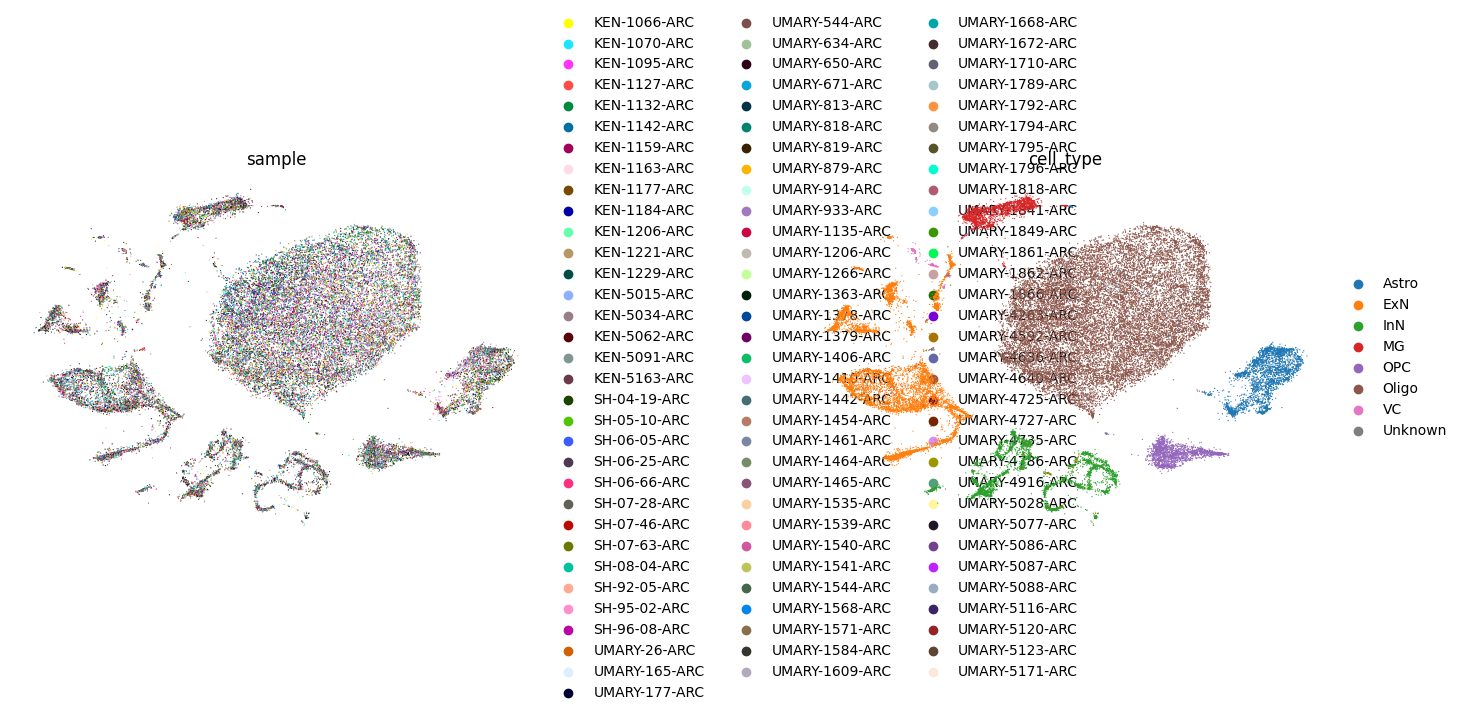

In [ ]:
# sc.pl.umap(adata, color=['study', 'cell_type'], wspace=0.35)
# # sc.pl.umap(adata, color=['study', 'cell_type'], wspace=0.35)

sc.pl.embedding(
    train_ad,
    basis="X_mde2",
    color=["sample", "cell_type"],
    frameon=False,
    wspace=0.35,
)


In [ ]:
preds = cvae.classifier(means).argmax(dim=-1)
labs = torch.tensor(encoder_celltype.transform(train_ad.obs['cell_type']))
accuracy = (preds==labs).sum().item()/train_ad.n_obs

In [ ]:
encoder_celltype.inverse_transform(preds)

array(['VC', 'Oligo', 'ExN', ..., 'MG', 'Oligo', 'Oligo'], dtype=object)

In [ ]:
train_ad.n_obs

tensor([[ 2.9354,  1.8235, -0.1486,  ...,  0.0210, -0.0204, -0.0467],
        [-0.2977,  0.7406,  0.3860,  ..., -0.0677,  0.0308, -0.0242],
        [-0.5130,  2.4466,  0.7728,  ...,  0.0406, -0.0267, -0.0259],
        ...,
        [ 1.0070,  1.5476,  1.7903,  ..., -0.0081,  0.0225, -0.0481],
        [-0.5239, -0.5073,  0.7861,  ..., -0.0812,  0.0437,  0.0175],
        [-1.6937, -0.1083,  1.2423,  ..., -0.0870,  0.0597,  0.0088]],
       grad_fn=<SliceBackward0>)

In [ ]:
import torch.nn.functional as F
from torch.distributions import Categorical

# Example logits from a neural network output
logits = cvae.classifier(means)

# Applying softmax to convert logits to probabilities
probabilities = F.softmax(logits, dim=1)

# Create a Categorical distribution
distribution = Categorical(probs=probabilities)

# Calculate entropy
entropy = distribution.entropy()

n_classes = probabilities.shape[1]

In [ ]:
probabilities[1,:].sum()

tensor(1., grad_fn=<SumBackward0>)

In [ ]:

logs = logits.detach().numpy()
probs = probabilities.detach().numpy()
ents = entropy.detach().numpy()
logents = entropy.log().detach().numpy()
maxprob = probs.max(axis=1)

# print("Logits: ", logs)
# print("Probabilities: ", probs)

maxprobs = probs.max(axis=1)


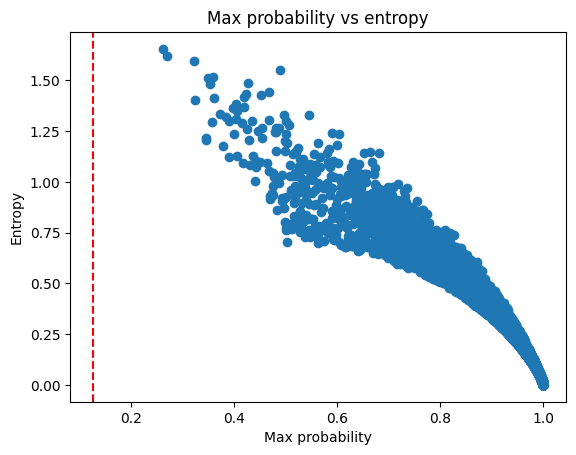

In [ ]:
# print("Entropy:", entropy)

# plt.scatter(means[:, 0], means[:, 1], c=entropy)

ax = plt.scatter(maxprobs,ents)
plt.xlabel("Max probability")
plt.ylabel("Entropy")
plt.title("Max probability vs entropy")
plt.axvline(x=1/n_cats, color='r', linestyle='--')


In [ ]:
cvae.classifier(means).argmax(dim=-1)

tensor([7, 5, 1,  ..., 3, 5, 5])

In [ ]:
torch.topk(probabilities, k=2, dim=1)
top_probs, _ = torch.topk(probabilities, k=2, dim=1)
top_probs[:,0] - top_probs[:,1]

tensor([0.9798, 0.9545, 0.7629,  ..., 0.9801, 0.9962, 0.9995],
       grad_fn=<SubBackward0>)

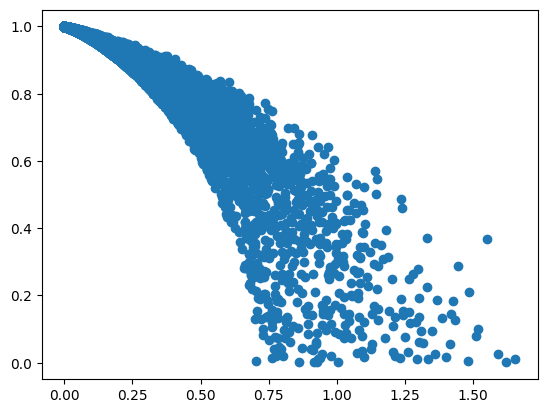

In [ ]:
def calculate_margin_of_probability(probabilities):

    # Get the top two probabilities
    top_probs, _ = torch.topk(probabilities, 2)

    # Calculate the margin
    margin = top_probs[:,0] - top_probs[:,1]
    return margin

# Get the top two probabilities
top_probs, _ = torch.topk(probabilities, k=2, dim=1)
# Calculate the margin
margin = top_probs[:,0] - top_probs[:,1]

# margs = calculate_margin_of_probability(probabilities)

plt.scatter(ents,margin.detach().numpy())



In [ ]:
train_ad.obs['margin'] = margin.detach().numpy()
train_ad.obs['entropy'] = entropy.detach().numpy()
train_ad.obs['maxprob'] = maxprob
train_ad.obs['pred'] = encoder_celltype.inverse_transform(preds)

/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


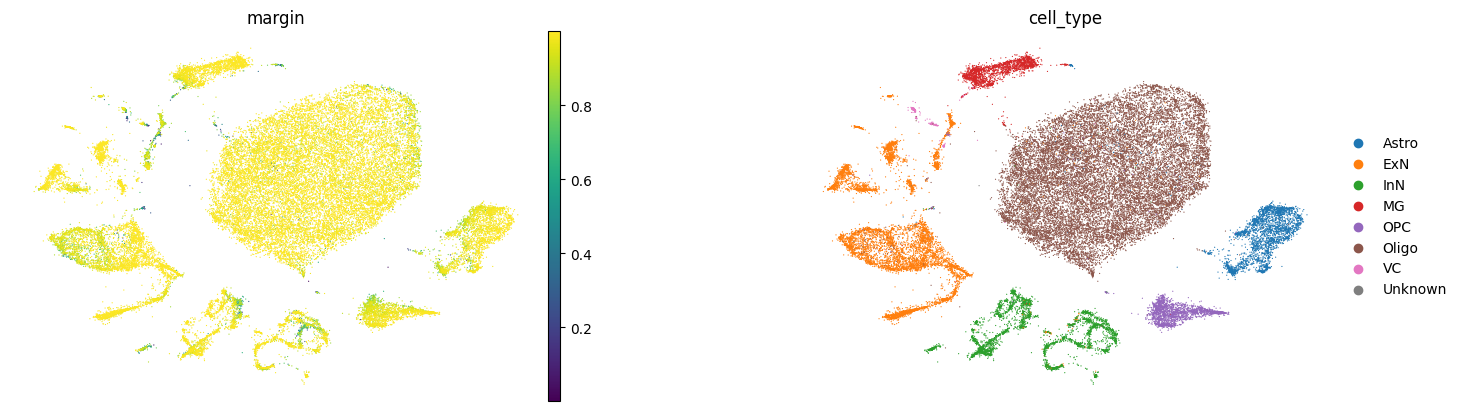

In [ ]:
sc.pl.embedding(
    train_ad,
    basis="X_mde2",
    color=["margin", "cell_type"],
    frameon=False,
    wspace=0.35,
)


/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


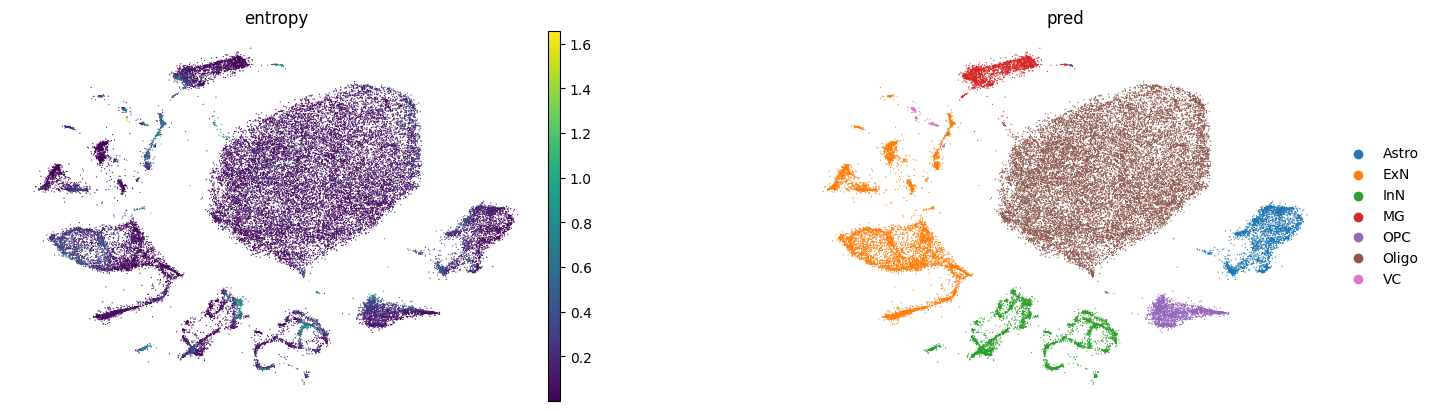

In [ ]:
sc.pl.embedding(
    train_ad,
    basis="X_mde2",
    color=["entropy", "pred"],
    frameon=False,
    wspace=0.35,
)


In [ ]:
train_ad.obs[train_ad.obs['cell_type']=='Unknown']

,seurat_clusters,cell_type,sample,doublet_score,nCount_RNA,nFeature_RNA,percent.mt,percent.rb,batch,S.Score,...,UMAP_2,clean,test,train,tmp,size_factors,margin,entropy,maxprob,pred
cells,,,,,,,,,,,,,,,,,,,,,
CACATAATCAAACCGT-1_138,1,Unknown,UMARY-933-ARC,0.089965,11383,4936,0.131775,1.511025,batch5,-0.070626,...,-9.666387,True,False,True,nanOligodendrocytes,4374.0,0.236207,1.085259,0.54742,ExN


In [ ]:
df = test_ad.obs.groupby(["C_scANVI", "ground_truth"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title(f"scanvi accuracy: {np.mean(test_ad.obs.C_scANVI == test_ad.obs.ground_truth):.3f}")